# MultiLayer Perceptron Classification Example


A data set that identifies different types of Iris's is used to demonstrate the use of multi layer perceptron in SAP HANA.  This data set is also used in a clustering example where the objective was to cluster the flowers into three clusters and the intuition was that the three clusters would correspond to the three types of Iris's in the data set.  Since we know the labels (i.e. the types of Iris's), we can use classification to create a model to predict the type of flower based on features or characteristics that are explained below.

## Iris Data Set
The data set used is from University of California, Irvine (https://archive.ics.uci.edu/ml/datasets/iris). For tutorials use only.  This data set contains attributes of a plant iris.  There are three species of Iris plants.
<table>
<tr><td>Iris Setosa</td><td><img src="images/Iris_setosa.jpg" title="Iris Sertosa" style="float:left;" width="300" height="50" /></td>
<td>Iris Versicolor</td><td><img src="images/Iris_versicolor.jpg" title="Iris Versicolor" style="float:left;" width="300" height="50" /></td>
<td>Iris Virginica</td><td><img src="images/Iris_virginica.jpg" title="Iris Virginica" style="float:left;" width="300" height="50" /></td></tr>
</table>

The data contains the following attributes for various flowers:
<table align="left"><tr><td>
<li align="top">sepal length in cm</li>
<li align="left">sepal width in cm</li>
<li align="left">petal length in cm</li>
<li align="left">petal width in cm</li>
</td><td><img src="images/sepal_petal.jpg" style="float:left;" width="200" height="40" /></td></tr></table>

Although the flower is identified in the data set, we will cluster the data set into 3 clusters since we know there are three different flowers.  The hope is that the cluster will correspond to each of the flowers.

A different notebook will use a classification algorithm to predict the type of flower based on the sepal and petal dimensions.

In [1]:
%matplotlib inline
from hana_ml import dataframe
from hana_ml.algorithms.pal.neural_network import MLPClassifier, MLPRegressor
from hana_ml.algorithms.pal import metrics

## Load data
The data is loaded into 4 tables - full set, test set, training set, and the validation set:
<li>IRIS_DATA_FULL_TBL</li>
<li>IRIS_DATA_TRAIN_TBL</li>
<li>IRIS_DATA_TEST_TBL</li>
<li>IRIS_DATA_VALIDATION_TBL</li>

To do that, a connection is created and passed to the loader.

There is a config file, <b>config/e2edata.ini</b> that controls the connection parameters and whether or not to reload the data from scratch.  In case the data is already loaded, there would be no need to load the data.  A sample section is below.  If the config parameter, reload_data is true then the tables for test, training, and validation are (re-)created and data inserted into them.

#########################<br>
[hana]<br>
url=host.sjc.sap.corp<br>
user=username<br>
passwd=userpassword<br>
port=3xx15<br>
<br>

#########################<br>

In [2]:
from data_load_utils import DataSets, Settings
import plotting_utils
url, port, user, pwd = Settings.load_config("../../config/e2edata.ini")
connection_context = dataframe.ConnectionContext(url, port, user, pwd)
full_tbl, training_tbl, validation_tbl, test_tbl = DataSets.load_iris_data(connection_context)

Table IRIS_DATA_FULL_TBL exists and data exists


# Create Data Frames
Create the data frames for the full, test, training, and validation sets.

Let us also do some data exploration.

## Define Datasets - Training, validation, and test sets
Data frames are used keep references to data so computation on large data sets in HANA can happen in HANA.  Trying to bring the entire data set into the client will likely result in out of memory exceptions.

The original/full dataset is split into training, test and validation sets.  In the example below, they reside in different tables.

In [3]:
full_set = connection_context.table(full_tbl)
training_set = connection_context.table(training_tbl)
validation_set = connection_context.table(validation_tbl)
test_set = connection_context.table(test_tbl)

## Simple Exploration
Let us look at the number of rows in the data set

In [4]:
print('Number of rows in full set: {}'.format(full_set.count()))
print('Number of rows in training set: {}'.format(training_set.count()))
print('Number of rows in validation set: {}'.format(validation_set.count()))
print('Number of rows in test set: {}'.format(test_set.count()))

Number of rows in full set: 150
Number of rows in training set: 75
Number of rows in validation set: 60
Number of rows in test set: 15


### Let's look at the columns

In [5]:
print(full_set.columns)

['ID', 'SEPALLENGTHCM', 'SEPALWIDTHCM', 'PETALLENGTHCM', 'PETALWIDTHCM', 'SPECIES']


### Let us look at some rows

In [6]:
full_set.head(5).collect()

,ID,SEPALLENGTHCM,SEPALWIDTHCM,PETALLENGTHCM,PETALWIDTHCM,SPECIES
0,1,4.3,3.0,1.1,0.1,Iris-setosa
1,2,6.3,3.4,5.6,2.4,Iris-virginica
2,3,6.1,3.0,4.6,1.4,Iris-versicolor
3,4,6.4,3.2,4.5,1.5,Iris-versicolor
4,5,6.2,2.9,4.3,1.3,Iris-versicolor


### Let's look at the data types

In [7]:
full_set.dtypes()

[('ID', 'INT', 10),
 ('SEPALLENGTHCM', 'DOUBLE', 15),
 ('SEPALWIDTHCM', 'DOUBLE', 15),
 ('PETALLENGTHCM', 'DOUBLE', 15),
 ('PETALWIDTHCM', 'DOUBLE', 15),
 ('SPECIES', 'NVARCHAR', 15)]

### Let's check how many SPECIES are in the data set.

In [8]:
full_set.distinct("SPECIES").collect()

,SPECIES
0,Iris-setosa
1,Iris-virginica
2,Iris-versicolor


## Create Model
The lines below show the ease with which clustering can be done.

Set up the features and labels for the model and create the model

In [9]:
%matplotlib inline
from plotting_utils import DrawNN
features = ['SEPALLENGTHCM','SEPALWIDTHCM','PETALLENGTHCM','PETALWIDTHCM']
label = 'SPECIES'

### Neural Network Architecture

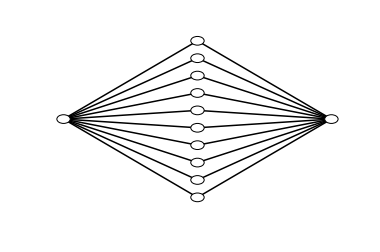

In [10]:
network = DrawNN( [1, 10, 1] )
network.draw(False)

### Model Creation

In [11]:
mlpc = MLPClassifier(connection_context, hidden_layer_size=(10,), activation='TANH', output_activation='TANH',
                     training_style='batch', max_iter=100, normalization='z-transform',
                     weight_init='uniform', thread_ratio=1)
mlpc.fit(training_set, 'ID', features, label)

### Model Storage

In [23]:
from hana_ml.model_storage import ModelStorage

# Creates an object model_storage
MODEL_SCHEMA='STORAGE'
# model storage must use the same connection than the model
model_storage = ModelStorage(connection_context=mlpc.conn_context,
                             schema=MODEL_SCHEMA)

# Saves the model
mlpc.name = 'Model A'  # The model name is mandatory
mlpc.version = 1
model_storage.save_model(model=mlpc)
#need to increase version

# Lists models
model_storage.list_models()


,NAME,VERSION,LIBRARY,CLASS,JSON,TIMESTMP,MODEL_STORAGE_VER
0,Model A,1,PAL,hana_ml.algorithms.pal.neural_network.MLPClass...,"{""model_attributes"": {""thread_ratio"": 1, ""para...",2019-07-28 07:33:52,1
1,Model A,2,PAL,hana_ml.algorithms.pal.neural_network.MLPClass...,"{""model_attributes"": {""thread_ratio"": 1, ""para...",2019-07-28 07:33:59,1


Model can be deleted in HANA DB accoridng to model name and version.

In [24]:
model_storage.delete_model('Model A', 1)
model_storage.list_models()

mod_name: hana_ml.algorithms.pal.neural_network


,NAME,VERSION,LIBRARY,CLASS,JSON,TIMESTMP,MODEL_STORAGE_VER
0,Model A,2,PAL,hana_ml.algorithms.pal.neural_network.MLPClass...,"{""model_attributes"": {""thread_ratio"": 1, ""para...",2019-07-28 07:33:59,1


In [26]:
model_storage.list_models()['JSON'].iloc[0]

'{"model_attributes": {"thread_ratio": 1, "param_range": null, "param_values": null, "progress_indicator_id": null, "timeout": null, "random_state": null, "random_search_times": null, "search_strategy": null, "repeat_times": null, "fold_num": null, "evaluation_metric": null, "resampling_method": null, "categorical_variable": null, "weight_init": "uniform", "normalization": "z-transform", "batch_size": null, "momentum": null, "learning_rate": null, "training_style": "batch", "max_iter": 100, "hidden_layer_size_options": null, "hidden_layer_size": [10], "output_activation_options": null, "output_activation": "TANH", "activation_options": null, "activation": "TANH"}, "artifacts": {"schema": "STORAGE", "model_tables": {"model_": "HANAML_MODEL_A_2_CLASS_HANA_ML_ALGORITHMS_PAL_NEURAL_NETWORK_MLPCLASSIFIER_MODELS"}, "library": "PAL"}}'

In [27]:
model = model_storage.load_model(name='Model A', version=2)

mod_name: hana_ml.algorithms.pal.neural_network


In [30]:
model.predict(data=test_set, key='ID', features=features)[0].collect()

,ID,TARGET,VALUE
0,1,Iris-versicolor,0.623920
1,2,Iris-virginica,0.393503
2,3,Iris-versicolor,0.443119
3,4,Iris-setosa,0.577828
4,5,Iris-versicolor,0.629952
5,6,Iris-virginica,0.596718
6,7,Iris-setosa,0.563213
7,8,Iris-setosa,0.571984
8,9,Iris-setosa,0.535048
9,10,Iris-setosa,0.577982


## Evaluation

### Accuracy
Let us compute the accuracy on our training and test sets

In [12]:
accuracy = mlpc.score(training_set, 'ID', features, label)
print("Training set accuracy: %f" % accuracy)
print("Test set accuracy: %f" % mlpc.score(test_set, 'ID', features, label))

Training set accuracy: 0.980952
Test set accuracy: 0.977778


### Precision, Recall, Confusion Matrix
Accuracy is usually not a good metric to evaluate a model.  Above, we see that we do pretty well for both the training and test sets.
Let us look at another metric.

To do that we first inspect the results of our test_set predictions

In [13]:
predictions_df, soft_max_df = mlpc.predict(test_set, 'ID', features)
print(soft_max_df.head(5).collect())

   ID            CLASS  SOFTMAX_VALUE
0   1      Iris-setosa       0.582557
1   1  Iris-versicolor       0.206906
2   1   Iris-virginica       0.210537
3   2      Iris-setosa       0.592538
4   2  Iris-versicolor       0.199749


The function to get the confusion matrix takes in a single data frame with the true label and the predicted label.
So, let us construct this data frame by joining on the ID column.

In [14]:
ts = test_set.rename_columns({'ID': 'TID'}) #.cast('SPECIES', 'NVARCHAR(256)')
jsql = '{}."{}"={}."{}"'.format(predictions_df.quoted_name, 'ID', ts.quoted_name, 'TID')
results_df = predictions_df.join(ts, jsql, how='inner')
cm_df, classification_report_df = metrics.confusion_matrix(connection_context, results_df, key='ID', label_true='SPECIES', label_pred='TARGET') 

In [15]:
print("Confusion Matrix")
cm_df.collect()

Confusion Matrix


,SPECIES,TARGET,COUNT
0,Iris-virginica,Iris-virginica,15
1,Iris-virginica,Iris-versicolor,0
2,Iris-virginica,Iris-setosa,0
3,Iris-versicolor,Iris-virginica,1
4,Iris-versicolor,Iris-versicolor,14
5,Iris-versicolor,Iris-setosa,0
6,Iris-setosa,Iris-virginica,0
7,Iris-setosa,Iris-versicolor,0
8,Iris-setosa,Iris-setosa,15


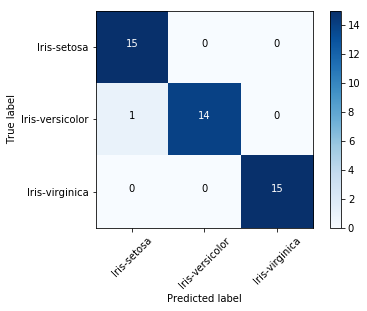

In [16]:
import matplotlib.pyplot as plt
from hana_ml.visualizers.metrics import MetricsVisualizer
f, ax1 = plt.subplots(1,1)
mv1 = MetricsVisualizer(ax1)
ax1 = mv1.plot_confusion_matrix(cm_df, normalize=False)

In [17]:
print("Recall, precision, and F-measures")
classification_report_df.collect()

Recall, precision, and F-measures


,CLASS,RECALL,PRECISION,F_MEASURE,SUPPORT
0,Iris-setosa,1.000000,1.0000,1.000000,15
1,Iris-versicolor,0.933333,1.0000,0.965517,15
2,Iris-virginica,1.000000,0.9375,0.967742,15
